## File Organization (Python 3.12.4)

To run the code create a folder. Inside that folder put preprocessing.ipynb. Create folders data > dataset > Free . Within the Free folder, put the unzipped IXI-PD and IXI-T2 folders. Return to the preprocessing file and run the code.

## Import The Required Packages

In [33]:
import os
import nibabel as nib # read MRI images
import numpy as np
import math
import time
import random
from tqdm import tqdm #time module progress bar
import matplotlib.pyplot as plt
from random import shuffle
import torch
from torch.utils.data import Dataset, DataLoader
import shutil # moving files
import json  # For saving patch names and mappings

## HammerSmith Data

In [36]:
def hammer_mri(num1,num2,num3):
    base_dir = "./data/dataset/Free/"
    mods = ["IXI-T1","IXI-T2","IXI-PD"]  # Modalities
    total_num = num1 + num2 + num3 # total number of files
    
    for x in mods:
        input_dir = os.path.join(base_dir, x)

        for f in tqdm(os.listdir(input_dir),desc=f"Processing {x} - Filtering Hammersmith Files"):
            if 'HH' not in f:
                os.remove(os.path.join(base_dir, x,f))

 
        sorted_files = sorted(os.listdir(input_dir))
        random.shuffle(sorted_files)
        count = 0
        for f in tqdm(sorted_files,desc=f"Processing {x} - Limiting Count to {total_num} files"):
            count +=1
            if count > total_num:
                os.remove(os.path.join(base_dir,x,f))
        z = 0
        for f in tqdm(sorted_files,desc=f"Processing {x} - Sorting into Respective Sets"):
            original_file_path = os.path.join(base_dir,x,f)
            training_path = os.path.join(base_dir, x,"training")
            valid_path = os.path.join(base_dir, x,"validation")
            testing_path = os.path.join(base_dir, x,"testing")
            
            if not os.path.exists(training_path):
                os.makedirs(training_path)
            if not os.path.exists(valid_path):
                os.makedirs(valid_path)
            if not os.path.exists(testing_path):
                os.makedirs(testing_path)
            z+=1
            if z <= num1:
                shutil.move(original_file_path,training_path)
            elif num1 < z <= num1 + num2:
                shutil.move(original_file_path,valid_path)
            elif num1 + num2 <= z <= total_num:
                shutil.move(original_file_path,testing_path)

## 6 Image Deep Data

In [39]:
def extract_mid_slices():
    base_dir = "./data/dataset/Free/"
    mods = ["IXI-T1","IXI-T2","IXI-PD"]  # Modalities
    sets = ["training","validation","testing"]
    for x in mods:
        for y in sets:
            input_dir = os.path.join(base_dir, x, y)

            files = os.listdir(input_dir)

            for f in tqdm(files, desc=f"Processing {x}"):

                input_file_path = os.path.join(input_dir, f)

                img_nifti = nib.load(input_file_path)
                img_data = img_nifti.get_fdata()  # Shape: (height, width, depth)

                depth_total = img_data.shape[2] #z direction
            
                mid = random.randint(30, 90)  # Random slice between 30 and 90
                start_slice = max(0, mid - 3)
                end_slice = min(depth_total, mid + 3)

                middle_slices = img_data[:, :, start_slice:end_slice]

                middle_img_nifti = nib.Nifti1Image(middle_slices, affine=img_nifti.affine, header=img_nifti.header)
            
                nib.save(middle_img_nifti, input_file_path)

In [ ]:
def extract_mid_slices():
    base_dir = "./data/dataset/Free/"
    mods = ["IXI-T1", "IXI-T2", "IXI-PD"]  # Modalities
    sets = ["training", "validation", "testing"]
    for x in mods:
        for y in sets:
            input_dir = os.path.join(base_dir, x, y)

            files = os.listdir(input_dir)

            for f in tqdm(files, desc=f"Processing {x}"):
                input_file_path = os.path.join(input_dir, f)

                img_nifti = nib.load(input_file_path)
                img_data = img_nifti.get_fdata()  # Shape: (height, width, depth)

                # Adjust dimensions for T1 modality to match others
                if x == "IXI-T1":
                    img_data = np.transpose(img_data, (1, 2, 0))  # Example reshuffling; modify as needed

                depth_total = img_data.shape[2]  # z direction after alignment

                mid = random.randint(30, 90)  # Random slice between 30 and 90
                start_slice = max(0, mid - 3)
                end_slice = min(depth_total, mid + 3)

                middle_slices = img_data[:, :, start_slice:end_slice]

                middle_img_nifti = nib.Nifti1Image(middle_slices, affine=img_nifti.affine, header=img_nifti.header)

                nib.save(middle_img_nifti, input_file_path)


## Rician Noise Generator

In [42]:
def add_rice_noise(img, snr=10, mu=0.0, sigma=1): #adds rician noise to the data
    level = snr * np.max(img) / 100 #(snr - signal to noise ratio)
    size = img.shape
    x = level * np.random.normal(mu, sigma, size=size) + img #real noise
    y = level * np.random.normal(mu, sigma, size=size) #imaginary noise
    #return np.sqrt(x**2 + y**2).astype(np.int16) #magnitude of noise
    return np.sqrt(x**2 + y**2).astype(np.int16)

## Function that Applies Noise to the Data

In [45]:
def generate_noised_mri():
    base_dir = "./data/dataset/Free/"
    mods = ["IXI-T1","IXI-T2","IXI-PD"]  # Modalities
    sets = ["training","validation","testing"] 
    levels = [1, 7, 13]
    for m in levels:
        for x in mods:
            for y in sets:
                input_dir = os.path.join(base_dir, x, y)
                output_dir = "./data/dataset/noise_{}/{}/{}".format(m, x, y)
        
                if not os.path.exists(output_dir):#Create the output directory if DNE 
                    os.makedirs(output_dir)

                files = [f for f in os.listdir(input_dir)]
                        
                for file in tqdm(files, desc=f"Processing {x}"): #cool time module that shows the status bar
                    nii_img = nib.load(os.path.join(input_dir, file))
                    free_image = nii_img.get_fdata()  #Load  MRI image data
                    noised_image = add_rice_noise(free_image, snr=m)
                    noised_image = nib.Nifti1Image(noised_image, nii_img.affine, nii_img.header)
                    nib.save(noised_image, os.path.join(output_dir, file))

## Patch Generator for Training Data

In [48]:
def generate_patch():
    stride = 16
    ## potentially stride = size / 2
    size = 32
    depth = 6

    base_dir = "./data/dataset/Free/"
    mods = ["IXI-T1","IXI-T2","IXI-PD"]  # Modalities
    sets = ["training","validation","testing"]
    levels = [1, 7, 13]
    
    for n in levels:
        for x in mods:
            for d in sets:
                input_free_dir = os.path.join(base_dir, x, d)
                input_noised_dir = os.path.join("./data/dataset/noise_%s" % n, x, d)
                output_free_dir = os.path.join("./data/patchs32_32_%s/free" % n, x, d)
                output_noised_dir = os.path.join("./data/patchs32_32_%s/noised" % n, x, d)

                # Create output directories if they don't exist
                if not os.path.exists(output_free_dir):
                    os.makedirs(output_free_dir)
                if not os.path.exists(output_noised_dir):
                    os.makedirs(output_noised_dir)

                files = [f for f in os.listdir(input_free_dir)]

                for file in tqdm(files, desc=f"Processing {x} for Level {n}"):
                    free_img_path = os.path.join(input_free_dir, file)
                    noised_img_path = os.path.join(input_noised_dir, file)

                    free_img = nib.load(free_img_path).get_fdata()
                    noised_img = nib.load(noised_img_path).get_fdata()

                    free_img_set = None
                    noised_img_set = None
    
                    height, width, _ = free_img.shape

                    for y in range(0, height - size + 1, stride):
                        for x_pos in range(0, width - size + 1, stride):
                            free_img_temp = free_img[y:y+size, x_pos:x_pos+size, :].copy().transpose(2, 0, 1)
                            noised_img_temp = noised_img[y:y+size, x_pos:x_pos+size, :].copy().transpose(2, 0, 1)

                            # Reshape to (1, 1, depth, size, size)
                            free_img_temp = np.reshape(free_img_temp, (1, 1, depth, size, size))
                            noised_img_temp = np.reshape(noised_img_temp, (1, 1, depth, size, size))

                            if free_img_set is None:
                                free_img_set = free_img_temp
                                noised_img_set = noised_img_temp
                            else:
                                free_img_set = np.append(free_img_set, free_img_temp, axis=0)
                                noised_img_set = np.append(noised_img_set, noised_img_temp, axis=0)

                    
                    root1 = os.path.splitext(os.path.splitext(os.path.basename(free_img_path))[0])[0]
                    root2 = os.path.splitext(os.path.splitext(os.path.basename(noised_img_path))[0])[0]
                    
                    np.save(os.path.join(output_free_dir, root1 + f"-{n}" + ".npy"), free_img_set)
                    np.save(os.path.join(output_noised_dir, root2 + f"-{n}" + ".npy"), noised_img_set)

## Mix the Data and Combine the Patches

In [51]:
from glob import glob

# noised_file_paths = glob(
#     os.path.join("./data/patchs32_32_*", "noised", "*", "*")
# )
# free_file_paths = glob(
#     os.path.join("./data/patchs32_32_*", "free", "*", "*")
# )

def combine_patches():
    levels = [1, 7, 13] 
    categories = ['free', 'noised']
    mods = ["IXI-PD"]
    sets = ["training", "validation", "testing"]
    mixdata_dir = "./data/mixdata/"

    for mod in mods:
        for data_set in sets:
            free_patches = []
            noised_patches = []
            free_patch_names = [] 
            noised_patch_names = [] 

            for level in levels:
                free_dir = f"./data/patchs32_32_{level}/free/{mod}/{data_set}"
                noised_dir = f"./data/patchs32_32_{level}/noised/{mod}/{data_set}"

                free_files = sorted([f for f in os.listdir(free_dir)])
                noised_files = sorted([f for f in os.listdir(noised_dir)])
                
                for patch_file in tqdm(free_files, desc=f"    Loading patches for noise level {level} in {data_set} set"):
                    free_patch_path = os.path.join(free_dir, patch_file)
                    noised_patch_path = os.path.join(noised_dir, patch_file)
                    
                    # loading data
                    # TODO: move out of for loops
                    free_patch = np.load(free_patch_path)
                    noised_patch = np.load(noised_patch_path)

                    if free_patch.ndim > 1 and free_patch.shape[0] > 1:
                        # If the first dimension represents multiple patches, iterate and append names accordingly
                        for i in range(free_patch.shape[0]):
                            free_patches.append(free_patch[i])
                            noised_patches.append(noised_patch[i])
                            free_patch_names.append(f"{patch_file}_patch{i}")
                            noised_patch_names.append(f"{patch_file}_patch{i}")
                    else:
                        # Single patch per file
                        free_patches.append(free_patch)
                        noised_patches.append(noised_patch)
                        free_patch_names.append(patch_file)
                        noised_patch_names.append(patch_file)

            free_array = np.concatenate(free_patches, axis=0)  # Shape: (num_patches, 1, 6, 32, 32)
            noised_array = np.concatenate(noised_patches, axis=0)

            #print(f"# of free patches: {free_array.shape[0]}; # of free patch names: {len(free_patch_names)} ") #validation
            #print(f"# of noised patches: {noised_array.shape[0]}; # of noised patch names: {len(noised_patch_names)}")

            indices = np.arange(free_array.shape[0])
            np.random.shuffle(indices)
            free_shuffled = free_array[indices]
            noised_shuffled = noised_array[indices]

            free_shuffled_names = [free_patch_names[i] for i in indices]
            noised_shuffled_names = [noised_patch_names[i] for i in indices]
            numbered_free_names = {i: name for i, name in enumerate(free_shuffled_names)} # Create a mapping from index to patch name
            numbered_noised_names = {i: name for i, name in enumerate(noised_shuffled_names)}
            
            output_free_dir = os.path.join(mixdata_dir, 'free', mod, data_set)
            output_noised_dir = os.path.join(mixdata_dir, 'noised', mod, data_set)
            os.makedirs(output_free_dir, exist_ok=True)
            os.makedirs(output_noised_dir, exist_ok=True)

            free_output_path = os.path.join(output_free_dir, "combined_free.npy")
            noised_output_path = os.path.join(output_noised_dir, "combined_noised.npy")
            
            # TODO: move out of for loops
            np.save(free_output_path, free_shuffled)
            np.save(noised_output_path, noised_shuffled)
            
            #print(f"    Saved combined and shuffled free patches at '{free_output_path}' with shape {free_shuffled.shape}")
            #print(f"    Saved combined and shuffled noised patches at '{noised_output_path}' with shape {noised_shuffled.shape}\n")

            free_names_path = os.path.join(output_free_dir, "free_patch_names.json")
            noised_names_path = os.path.join(output_noised_dir, "noised_patch_names.json")

            # TODO: move out of for loops
            with open(free_names_path, 'w') as f:
                json.dump(numbered_free_names, f, indent=4)
            with open(noised_names_path, 'w') as f:
                json.dump(numbered_noised_names, f, indent=4)

## Testing Data

Testing phase to process new images after the model has been trained (Evaluate model performance on full images; generate output images). The patch test image function is used to extract patches from the test image.  When it extracts patches, it keeps track of their positions in the original image, which is necessary for accurate reconstruction (unlike generate_patch). The merge function combines the processed patches from the model back into a seamless image.

In [55]:
def patch_test_img(img, size=32):
    patchs = []
    height, width, depth = img.shape
    
    row = 0
                            
    for i in range(0, height-size+1, size//2):
        row += 1
        col = 0
        for j in range(0, width-size+1, size//2):
            col += 1
            patchs.append(img[i:i+size, j:j+size,:])
    temp = np.vstack(patchs)
    temp = np.reshape(temp, (-1, size, size, depth))
    return temp, row, col

Averages overlapping regions to ensure smooth transitions

In [58]:
def merge_test_img(patchs, row, col,size=32):
    
    patchs_num = patchs.shape[0]
    num = int(math.sqrt(patchs_num))
    rows = []
    x = size // 8
    y = size//4
    row_index = 0
    for i in range(0, patchs_num, col):
        temp = patchs[i,:,:-x,:]
        for j in range(1, col - 1):
            temp[:, -y:, :] = (temp[ :, -y:, :] + patchs[i+j, :,x:x+y,:]) / 2
            temp = np.append(temp, patchs[i + j, :, x+y:-x, :], axis=1)
        temp[:, -y:, :] = (temp[:, -y:, :] + patchs[i+j+1, :,x:x+y,:]) / 2
        temp = np.append(temp, patchs[i + j+1, :, x+y:, :], axis=1)
        
        a = row_index * 16
        b = row_index * 16 + 32
        row_index += 1
        rows.append(temp)
    img = rows[0][:-x,:,:]
    length = len(rows)
    for i in range(1, length-1):
        height = img.shape[0]
        img[-y:, :, :] = (img[-y:, :, :] + rows[i][x:x+y, :, :])/2
        img = np.append(img, rows[i][x+y:-x, :, :], axis=0)
    img[-y:, :, :] = (img[ -y:, :, :] + rows[-1][x:x+y, :, :]) / 2
    img = np.append(img, rows[-1][ x+y:, :, :], axis=0)
        
    return img

## Executable Block for Hammer Smith (70% training, 10% validation, 20% testing)

In [61]:
if __name__ == "__main__": #, Python sets __name__ to "__main__"
    hammer_mri(14,2,4)

Processing IXI-T1 - Filtering Hammersmith Files: 100%|█| 581/581 [00:00<00:00, 5
Processing IXI-T1 - Limiting Count to 20 files: 100%|█| 185/185 [00:00<00:00, 95
Processing IXI-T1 - Sorting into Respective Sets: 100%|█| 185/185 [00:00<00:00, 
Processing IXI-T2 - Filtering Hammersmith Files: 100%|█| 578/578 [00:00<00:00, 9
Processing IXI-T2 - Limiting Count to 20 files: 100%|█| 185/185 [00:00<00:00, 12
Processing IXI-T2 - Sorting into Respective Sets: 100%|█| 185/185 [00:00<00:00, 
Processing IXI-PD - Filtering Hammersmith Files: 100%|█| 579/579 [00:00<00:00, 1
Processing IXI-PD - Limiting Count to 20 files: 100%|█| 185/185 [00:00<00:00, 14
Processing IXI-PD - Sorting into Respective Sets: 100%|█| 185/185 [00:00<00:00, 


## Executable for 6 Deep Data (Make Sure to Eliminate File #IXI163(Corrupted) for both PD and T2)

In [64]:
if __name__ == "__main__":
    extract_mid_slices()

Processing IXI-PD: 100%|██████████████████████████| 4/4 [00:00<00:00, 12.69it/s]


## Executable Block for Noisy Images

In [67]:
if __name__ == "__main__":
        generate_noised_mri()

Processing IXI-PD: 100%|██████████████████████████| 4/4 [00:00<00:00, 26.08it/s]


## Executable Block for Patched Images

In [70]:
if __name__ == "__main__": #, Python sets __name__ to "__main__"
    generate_patch()

Processing IXI-PD for Level 13: 100%|█████████████| 4/4 [00:01<00:00,  3.27it/s]


## Executable Block for Shuffling and Combining Patches

In [31]:
if __name__ == "__main__":
    combine_patches()

    Loading patches for noise level 1 in training set: 100%|█| 35/35 [00:55<00:0
    Loading patches for noise level 7 in training set: 100%|█| 35/35 [00:03<00:0
    Loading patches for noise level 13 in training set: 100%|█| 35/35 [00:04<00:
    Loading patches for noise level 1 in validation set: 100%|█| 5/5 [00:00<00:0
    Loading patches for noise level 7 in validation set: 100%|█| 5/5 [00:02<00:0
    Loading patches for noise level 13 in validation set: 100%|█| 5/5 [00:00<00:
    Loading patches for noise level 1 in testing set: 100%|█| 10/10 [00:04<00:00
    Loading patches for noise level 7 in testing set: 100%|█| 10/10 [00:02<00:00
    Loading patches for noise level 13 in testing set: 100%|█| 10/10 [00:02<00:0


## Patch Test (Put in file path and index to view respective patch)

Patch 600 shape: (1, 6, 32, 32)


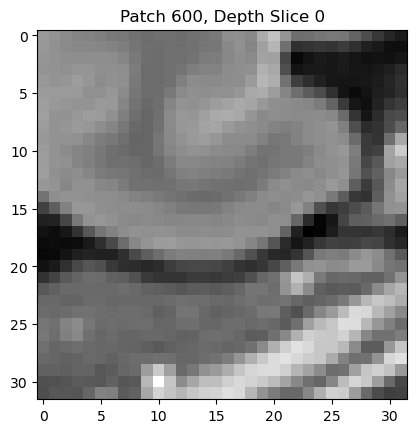

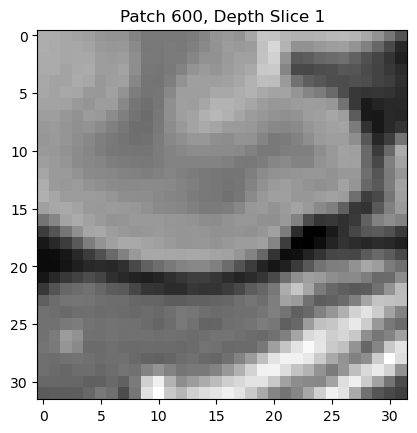

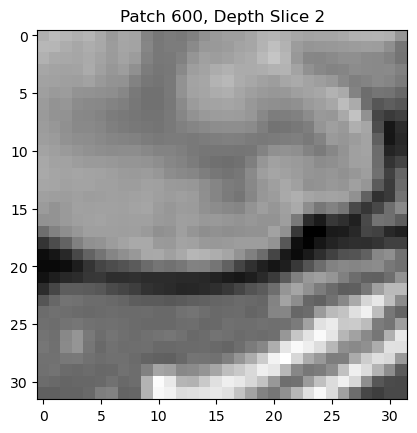

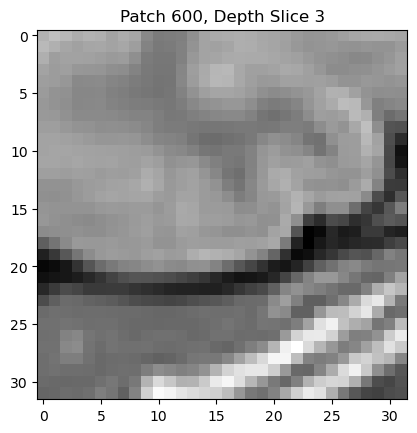

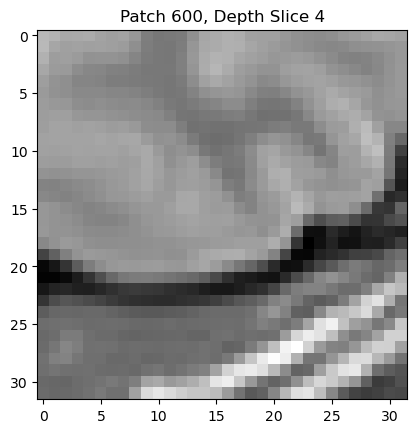

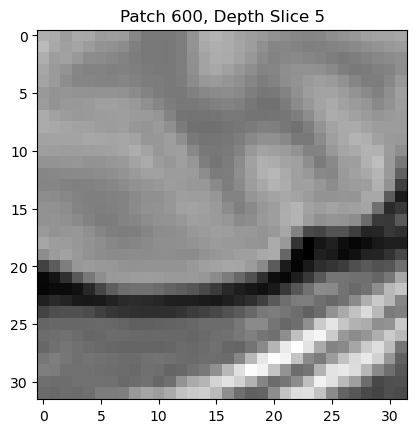

In [13]:
patches_file_path = '/Users/john_1john_1/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/MRI-Denoising-Project/data/patchs32_32_13/free/IXI-PD/testing/IXI176-HH-1604-PD-13.npy' 

patch_index = 600 

patches = np.load(patches_file_path)
num_patches = patches.shape[0]

if patch_index < 0 or patch_index >= num_patches:
    print(f"Patch index {patch_index} is out of bounds. Number of patches: {num_patches}")
else:
    patch = patches[patch_index]

    print(f"Patch {patch_index} shape: {patch.shape}")

    # If the patch has a singleton dimension for channels, remove it
    if patch.shape[0] == 1:
        patch = np.squeeze(patch, axis=0)  # Now shape is (depth, height, width)

    # Display each depth slice in the patch
    depth = patch.shape[0]
    for i in range(depth):
        plt.imshow(patch[i], cmap='gray')
        plt.title(f'Patch {patch_index}, Depth Slice {i}')
        plt.show()

In [17]:
"/Users/john_1john_1/Desktop/Backup Data/Free copy/IXI-PD/IXI176-HH-1604-PD.nii.gz"

'/Users/john_1john_1/Desktop/Backup Data/Free copy/IXI-PD/IXI176-HH-1604-PD.nii.gz'

In [47]:
def calculate_patch_coordinates_generate_patch(patch_index, image_shape, patch_size, stride):
    """
    Calculate the (y, x) coordinates of the patch based on the generate_patch logic.
    """
    height, width, depth = image_shape
    patch_height, patch_width, patch_depth = patch_size

    # Calculate the number of patches per row
    patches_per_row = (width - patch_width) // stride + 1

    # Unflatten the patch index to (y, x_pos)
    y = (patch_index // patches_per_row) * stride
    x_pos = (patch_index % patches_per_row) * stride

    # Map to start and end ranges
    start_row = y
    end_row = start_row + patch_height
    start_col = x_pos
    end_col = start_col + patch_width

    return (start_row, end_row), (start_col, end_col), depth


def visualize_patch_from_generate_patch(patch_file_path, patch_index, image_file_path, image_shape, patch_size, stride):
    """
    Visualizes the patch and ensures consistency with the original generate_patch indexing.
    """
    # Load patches
    patches_array = np.load(patch_file_path)
    num_patches = patches_array.shape[0]

    if patch_index < 0 or patch_index >= num_patches:
        print(f"Patch index {patch_index} is out of bounds. Number of patches: {num_patches}")
        return

    # Extract the patch for visualization
    patch = patches_array[patch_index]
    if patch.shape[0] == 1:  # Remove singleton dimension if present
        patch = np.squeeze(patch, axis=0)

    # Display the patch slices
    depth = patch.shape[0]
    for i in range(depth):
        plt.imshow(patch[i], cmap='gray')
        plt.title(f'Patch {patch_index}, Depth Slice {i}')
        plt.show()

    # Load the original MRI
    img = nib.load(image_file_path).get_fdata()

    # Calculate patch coordinates using generate_patch logic
    row_range, col_range, depth = calculate_patch_coordinates_generate_patch(
        patch_index, image_shape, patch_size, stride
    )

    # Debug: print coordinate mapping
    print(f"Patch Index: {patch_index}")
    print(f"Row Range: {row_range}")
    print(f"Column Range: {col_range}")
    print(f"Patch Shape: {patch.shape}")
    print(f"Image Shape: {img.shape}")

    # Extract and compare the corresponding region from the MRI
    start_row, end_row = row_range
    start_col, end_col = col_range
    mri_patch = img[start_row:end_row, start_col:end_col, 0]
    print(f"Extracted MRI Patch Shape: {mri_patch.shape}")

    # Visualize the MRI slice (depth 0) with the patch location
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img[:, :, 0], cmap="gray")  # Always use depth slice 0

    # Add rectangle to indicate patch location
    rect = patches.Rectangle(
        (start_col, start_row),  # x, y
        patch_size[1],  # width
        patch_size[0],  # height
        linewidth=2,
        edgecolor="red",
        facecolor="none"
    )
    ax.add_patch(rect)

    plt.title(f"Patch {patch_index} from generate_patch Logic on Depth Slice 0")
    plt.show()


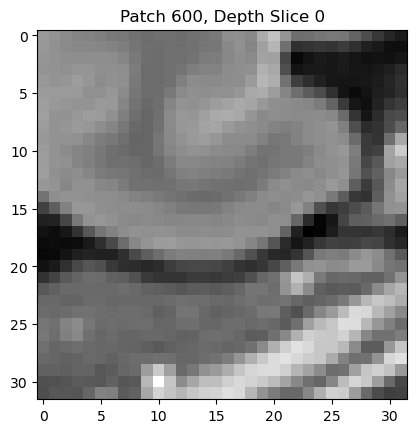

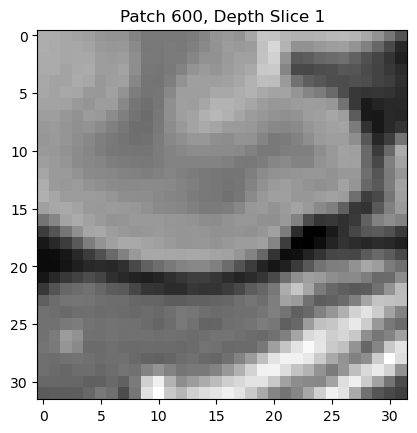

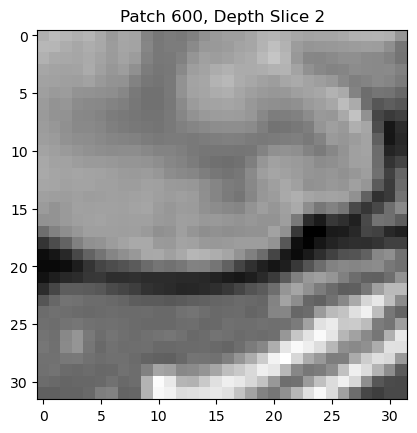

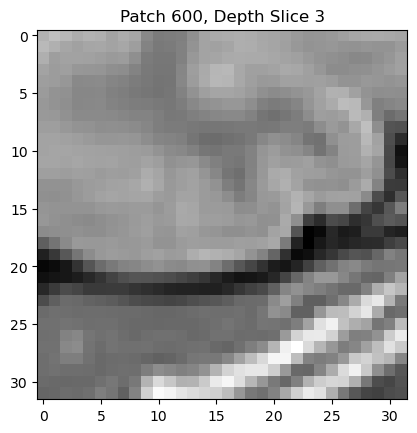

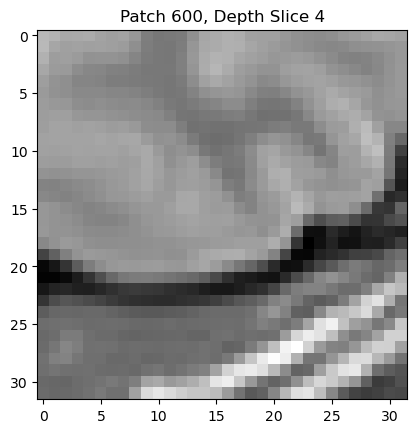

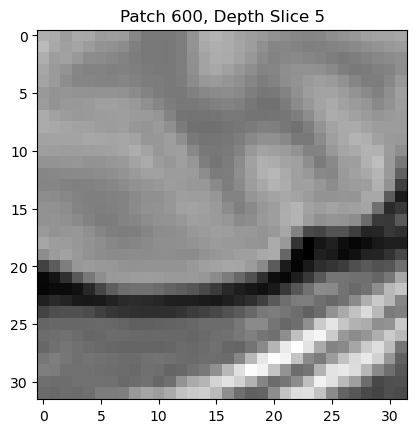

Patch Index: 600
Depth Index: 2
Row Range: (160, 192)
Column Range: (0, 32)
Patch Shape: (6, 32, 32)
Image Shape: (256, 256, 130)
Extracted MRI Patch Shape: (32, 32)


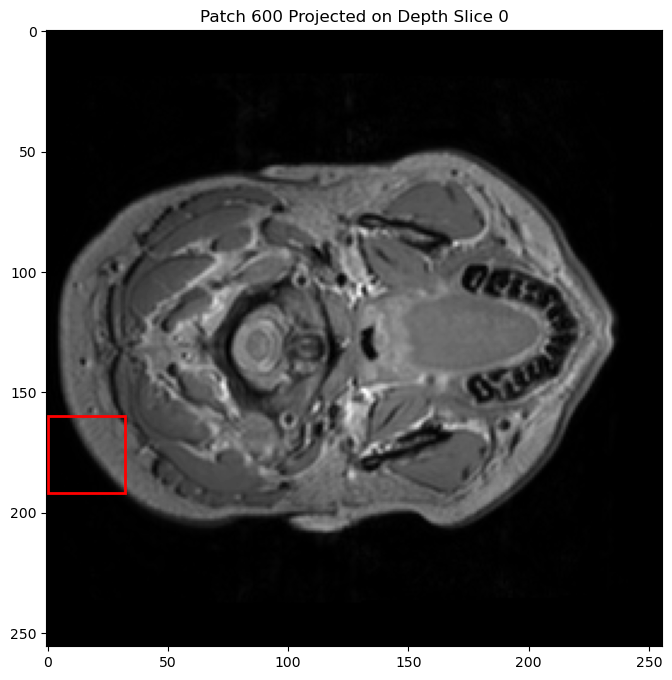

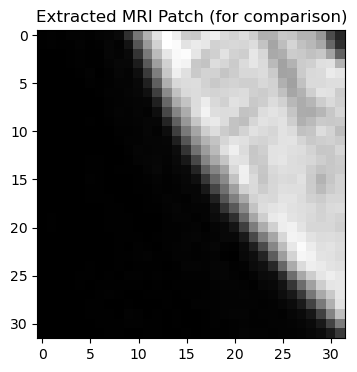

In [49]:
patch_file_path = '/Users/john_1john_1/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/MRI-Denoising-Project/data/patchs32_32_13/free/IXI-PD/testing/IXI176-HH-1604-PD-13.npy'
patch_index = 600
image_file_path = "/Users/john_1john_1/Desktop/Backup Data/Free copy/IXI-PD/IXI176-HH-1604-PD.nii.gz"  # Replace with the original MRI file path
image_shape = (256, 256, 130)  # Example original MRI dimensions
patch_size = (32, 32, 6)  # Match your patch generation logic
stride = 16
visualize_patch_with_debug(patch_file_path, patch_index, image_file_path, image_shape, patch_size, stride)